In [4]:
from init_notebook import *
%matplotlib inline

In [11]:
"""common imports"""

import typing as t
import os
import pandas as pd

from rat import pvwatts_api

# Get a PVWatts API key and set it:
# os.environ['PVWATTS_API_KEY'] = 'XXX'

pvwatts_api.assert_pvwatts_ready()

In [12]:
PLAYA_LAT = '40.786433'
PLAYA_LONG = '-119.206543'
PLAYA_START = '2021-08-29'  # Sunday
PLAYA_END = '2021-09-05'  # Sunday

# Example PVWatts Calculation

PVWatts returns a full year of of a couple metrics. The most important ones for us are:
- `ac`: AC modelled system production (watts)
- `dc`: DC modelled system production (watts)

We're going to ask PVWatts for an annual production, and then pluck out just the one week we care about.

Note how we specify a few system parameters to be modelled:
- `azimuth`: Which compass direction panels are facing. 0 is due north, 180 is due south.
- `tilt`: Angle of panels. 0 is laying flat facing straight up, 90 is facing the horizon.
- `system_capacity_kw`: Total power of your panels
- `losses`: Estimated total system losses (inverter, etc.)

In [36]:
pvwatts_json = pvwatts_api.v6_1_kw_solar_ac_production(
    PLAYA_LAT,
    PLAYA_LONG,
    azimuth=180,  # Pointing due south
    
    # 0 tilt is panels facing "straight up". 
    # A good rule of thumb for maximizing annual production is set your
    # panel tilt equal to the latitude.
    tilt=float(PLAYA_LAT),
    
    # Additional params. See api docs for details, defaults are:
#     system_capacity_kw: float = 1,
#     losses: float = 10,
#     country_code: str = 'US',
#     module_type: int = 0,
#     pvwatts_params: t.Optional[dict] = None,
).json()

In [37]:
from pprint import pprint
print('PVWatts used inputs:')
pprint(pvwatts_json['inputs'])

print('\nPVWatts used weather model from station:')
pprint(pvwatts_json['station_info'])

PVWatts used inputs:
{'array_type': '0',
 'azimuth': '180',
 'country_code': 'US',
 'dataset': 'nsrdb',
 'lat': '40.786433',
 'lon': '-119.206543',
 'losses': '10',
 'module_type': '0',
 'radius': '0',
 'system_capacity': '1',
 'tilt': '40.786433',
 'timeframe': 'hourly'}

PVWatts used weather model from station:
{'city': '',
 'distance': 2157,
 'elev': 1178.319946289062,
 'lat': 40.77000045776367,
 'location': 'None',
 'lon': -119.2200012207031,
 'solar_resource_file': 'W11922N4077.csv',
 'state': 'Nevada',
 'tz': -8.0}


## Pandas DataFrames: Easier PVWatts Manipulation
By converting PVWatts annual results into a pandas DataFrame, we can start doing some useful slicing, dicing, and plotting of our 1 kW system.

In [38]:
df = pvwatts_api.resp_to_df(pvwatts_json)
df

,ac,dc,temp_amb,temp_cell,irr_diffuse,irr_poa,irr_normal
2021-01-01 00:00:00,0.0,0.0,-2.0,-2.0,0.0,0.0,0.0
2021-01-01 01:00:00,0.0,0.0,-2.0,-2.0,0.0,0.0,0.0
2021-01-01 02:00:00,0.0,0.0,-2.0,-2.0,0.0,0.0,0.0
2021-01-01 03:00:00,0.0,0.0,-3.0,-3.0,0.0,0.0,0.0
2021-01-01 04:00:00,0.0,0.0,-3.0,-3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2021-12-31 19:00:00,0.0,0.0,-2.0,-2.0,0.0,0.0,0.0
2021-12-31 20:00:00,0.0,0.0,-2.0,-2.0,0.0,0.0,0.0
2021-12-31 21:00:00,0.0,0.0,-2.0,-2.0,0.0,0.0,0.0
2021-12-31 22:00:00,0.0,0.0,-2.0,-2.0,0.0,0.0,0.0


<AxesSubplot:title={'center':'DC Production (watts)'}>

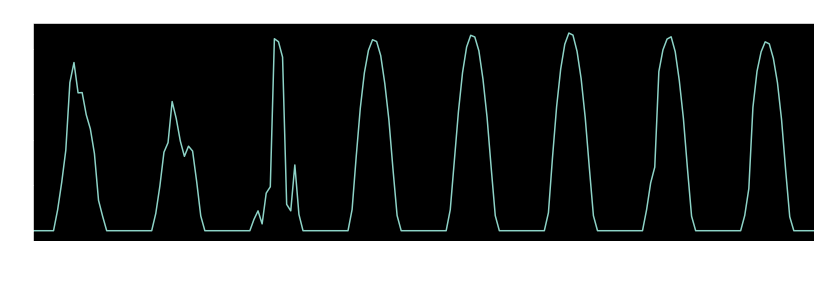

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(14,4))
df[PLAYA_START:PLAYA_END]['dc'].plot(title="DC Production (watts)")

Here we've plotted DC production of the system for the week defined by PLAYA_START:PLAYA_END.

Note that not all days are uniform. PVWatts uses a weather model of the location based on nearby weather stations. Every day may be different, but in theory, the day-to-day variations over a long period of time should be representative of what performance may be expected at the lat/long.

Next, lets compare these results vs. changing a system parameter. Lets say instead of the panels facing due south, we point them a bit west to get some more direct evening light.

In [41]:
pvwatts_json_sxsw = pvwatts_api.v6_1_kw_solar_ac_production(
    PLAYA_LAT,
    PLAYA_LONG,
    azimuth=180 + 45,  # South by South-West
    tilt=float(PLAYA_LAT),
).json()
df_sxsw = pvwatts_api.resp_to_df(pvwatts_json_sxsw)

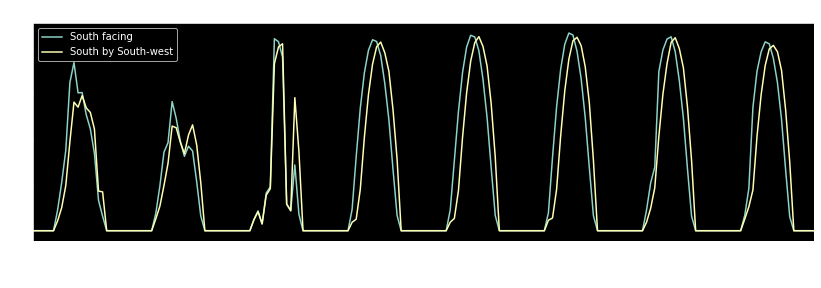

In [50]:
# and plot it:
fig, ax = plt.subplots(1, 1, figsize=(14,4))

df_joint_dc = pd.DataFrame({
    'South facing': df['dc'],
    'South by South-west': df_sxsw['dc'],
})

df_joint_dc[PLAYA_START:PLAYA_END].plot(ax=ax, title="DC Production (watts)")
plt.legend()

Note how the production curves are now shifted later into the day, as would be expected from getting a more direct angle onto the sun later in the day. This could give you more *instanteous* power later in the day, eg when it's hot and you need your fridge running more, but generally this gives you less *overall* kWh production.

We can see this by charting cumulative power production for the two arrangements:

<AxesSubplot:title={'center':'Cumulative power production (Wh)'}>

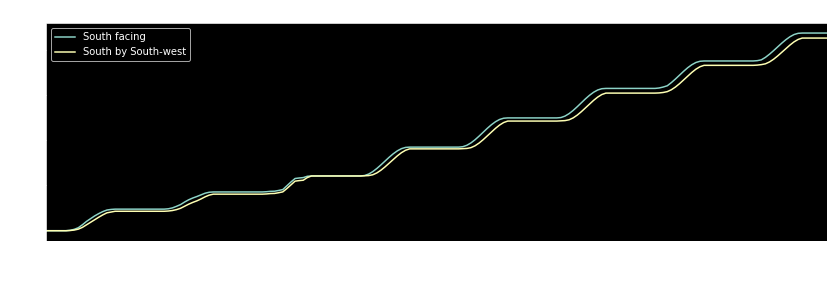

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(14,4))
df_joint_dc[PLAYA_START:PLAYA_END].cumsum().plot(ax=ax, title='Cumulative power production (Wh)')

# Tilt Optimization by Parameter Bisect Sweeping

A common rule of thumb used in the solar industry is your optimal panel tilt is equal to your lattitude. Ignoring weather effects, this generally gives you good production year round.

However, we're interested in maximal production for only a single week. There's probably some astrophysics geometry problem you can work out to find the optimal value, or we can numerically derive it by running a few calculations sweeping the `tilt` parameter until we find the local maximum.

Lets run a simple parameter sweep algorithm that bisects different parameter runs:
- For a given `tilt` parameter value, we define it's "optimization metric" as the cumulative number of Wh's produced during our week of interest
- We start with calculations at 0-degree-tilt (facing straight up) and 90-degree-tilt (facing towards the horizon)
- For each iteration,
    - Find the parameter (tilt) with the maximum metric (ie maximum 7-day kWh production)
    - Of the two adjacent parameter values, find the parameter (tilt) with the larger value
    - Run the calculation with the parameter value that is in the middle of the two
- Repeat this until you reach some threshold in next parameter values (eg delta of 1 or 2 degrees)

For example:
- We start with 0 and 90 degree tilt calculations
- We bisect those two into 45 degrees
- We run the production simulation at `tilt=45 degrees`
- Next iteration: Lets now say 45 degrees produces the largest production
- Now we run the production simulation at `tilt=22.5 degrees` or `67.5 degrees`, depending on whether `tilt=0` or `tilt=90` had higher production (respectively)
- Keep on bisecting like this until our next tilt angle is within 1 or 2 degrees of previous one (about 6 iterations or so)

In [57]:
from rat import parameter_sweep

def calc_by_tilt(dfs_by_tilt: dict, tilt: float):
    json = pvwatts_api.v6_1_kw_solar_ac_production(
        PLAYA_LAT,
        PLAYA_LONG,
        tilt=tilt,
        azimuth=180,  # due south, constant
    ).json()
    df = pvwatts_api.resp_to_df(json)
    dfs_by_tilt[tilt] = df
    return df

def score_pvwatts_output(df_pvwatts):
    """Return the total DC production during playa period"""
    return df_pvwatts[PLAYA_START:PLAYA_END]['dc'].sum()

In [59]:
"""Run the calculation loop"""

# Initialize to 0 and 90 results:
dfs_by_tilt = {}

calc_by_tilt(dfs_by_tilt, 0)
calc_by_tilt(dfs_by_tilt, 90)

# Loop init: Bisecting 0 and 90 is 45
next_tilt = 45

# Loop until our bisection results in less than 2 degree change
for n in range(10):  # we shouldn't need more than 10 iterations... use 10 as max limit incase bug
    print(f'\n------\nIteration [{n}]:')
    print('Calcing next tilt: ', next_tilt)
    calc_by_tilt(dfs_by_tilt, next_tilt)
    
    new_next_tilt = parameter_sweep.parameter_maximizing_bisection(dfs_by_tilt, score_pvwatts_output)
    print('Next tilt should be at: ', new_next_tilt)
    
    if -1 < (new_next_tilt - next_tilt) < 1:
        print("Next tilt is within a degree of current tilt. We're done here.")
        break
    
    next_tilt = new_next_tilt


------
Iteration [0]:
Calcing next tilt:  45
Next tilt should be at:  22.5

------
Iteration [1]:
Calcing next tilt:  22.5
Next tilt should be at:  33.75

------
Iteration [2]:
Calcing next tilt:  33.75
Next tilt should be at:  28.125

------
Iteration [3]:
Calcing next tilt:  28.125
Next tilt should be at:  30.9375

------
Iteration [4]:
Calcing next tilt:  30.9375
Next tilt should be at:  32.34375

------
Iteration [5]:
Calcing next tilt:  32.34375
Next tilt should be at:  31.640625
Next tilt is within a degree of current tilt. We're done here.


,tilt,sum_dc_production
0,0.00000,38883.425
3,22.50000,43684.474
5,28.12500,44045.118
6,30.93750,44100.790
7,32.34375,44097.569
4,33.75000,44073.673
2,45.00000,43142.503
1,90.00000,26720.916


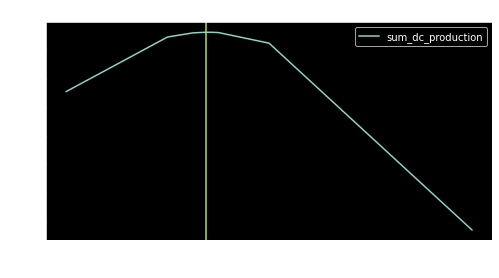

In [64]:
# Now we can summarize results and plot the sweep results
df_tilts = pd.DataFrame.from_records([
    {"tilt": t, "sum_dc_production": score_pvwatts_output(df)}
    for t, df in dfs_by_tilt.items()
]).sort_values('tilt')

best_tilt = df_tilts.set_index('tilt')['sum_dc_production'].idxmax()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
df_tilts.plot(ax=ax, x="tilt", y="sum_dc_production")
ax.axvline(best_tilt, color=CMAP.green)
ax.set_title(f'Max production (Wh) at tilt={best_tilt} deg')

df_tilts

### 31 Degrees
That's our optimal panel tilt (facing due south) to maximize production during the one week

# Production Variance
As mentioned, PVWatts uses a weather model to account for typical cloud cover based off of regional datasets.

Another interesting question might be to plot our daily production and see how much the PVWatts model shows we should expect to have results vary by.

Text(0.5, 1.0, 'Daily 1kW panel production (kWh), with playa week highlighted')

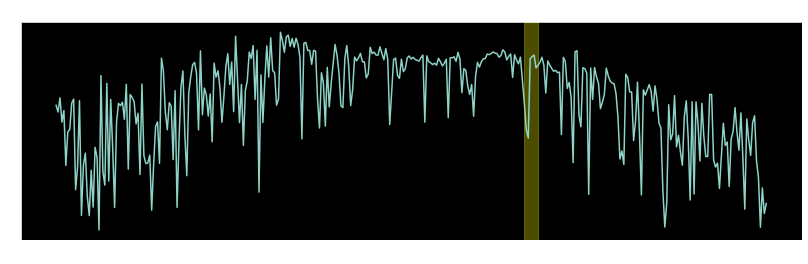

In [77]:
df_best = dfs_by_tilt[best_tilt]
daily_productions_kwh = df_best.groupby(df_best.index.date)['dc'].sum() / 1000

fig, ax = plt.subplots(1, 1, figsize=(14,4))
daily_productions_kwh.plot(ax=ax)
ax.axvspan(PLAYA_START, PLAYA_END, color='yellow', alpha=0.3)
ax.set_title('Daily 1kW panel production (kWh), with playa week highlighted')


We can visualize this in a few more ways. For example, lets consider a wider time period (2 weeks prior through 2 weeks after)...

In [116]:
period_start = (pd.Timestamp(PLAYA_START) - pd.DateOffset(weeks=2)).date()
period_end = (pd.Timestamp(PLAYA_END) + pd.DateOffset(weeks=2)).date()

print(f'Considering period {period_start} - {period_end}')

period_productions = daily_productions_kwh[period_start:period_end].sort_values()

print('\n\nDaily Production (kWh) summary statistics:')
period_productions.describe()

Considering period 2021-08-15 - 2021-09-19


Daily Production (kWh) summary statistics:


count    36.000000
mean      6.025505
std       0.803641
min       3.595820
25%       5.969139
50%       6.309458
75%       6.486809
max       6.745408
Name: dc, dtype: float64

By considering the summary statistics, we can see our 1kW panel, south-facing optimal tilt system could produce **at best 6.7kWh per day**.

In this region at this time of year, we should expect an **average of 6.0 kWh per day.**

However, 25% of days produce less than 5.9 kWh, with the worst day producing only 3.6 kWh, or almost half of our best-case scenarios.

By plotting the full period's daily productions as a CDF, we can get a better idea of our bad-day likelihoods:

Text(0.5, 1.0, 'CDF: Probability of day with at-most x kWh produced, 2021-08-15 - 2021-09-19 ')

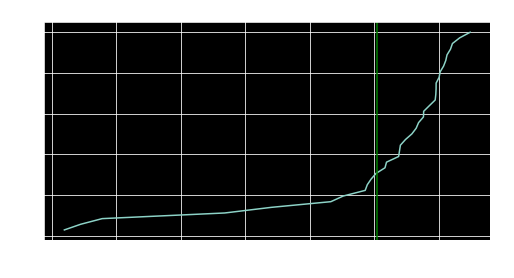

In [119]:
df_cdf = pd.DataFrame({
    'production_kwh': period_productions, 
    'rank': period_productions.rank(method='average', pct=True)
})

fig, ax = plt.subplots(1,1, figsize=(8,4))
df_cdf.plot(ax=ax, x='production_kwh', y='rank', grid=True)

# Add a green line for the average (mean) production
ax.axvline(period_productions.mean(), color='green')

ax.legend().remove()
ax.set_xlabel('Max Daily Production (kWh)')
ax.set_ylabel('Probability')
ax.set_title(f'CDF: Probability of day with at-most x kWh produced, {period_start} - {period_end} ')

For example, with a view like this, we can see that 20% of days (or 1 in 5) will produce no more than about 5.75 kWh. 10% will produce no more than 4 kWh.